In [39]:
import os
import json
import random
import numpy as np
from pathlib import Path
from typing import Optional
import matplotlib.pyplot as plt
from tokenizers import ByteLevelBPETokenizer

In [40]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [41]:
vocab_size = 50000
num_heads = 6
max_sequence_length = 512 
d_model = num_heads * 64
head_dim = d_model // num_heads
batch_size = 32

# Lookup table  
embedding = np.random.randn(vocab_size, d_model) * 0.01

token_ids = [123, 456, 789, 5]
embeded = embedding[token_ids]

embeded.shape

(4, 384)

In [42]:
wiki_data_dir = Path("../data/raw/wiki")
news_data_dir = Path("../data/raw/news")
github_repos_dir = Path("../data/raw/github_repos")

files = [
    str(wiki_data_dir / "wiki.jsonl"),
    str(news_data_dir / "news.jsonl"),
    str(github_repos_dir / "corpus.jsonl")
]

encoded_corpus = []
tokenizer = ByteLevelBPETokenizer(
    "../data/processed/tokenizer/vocab.json",
    "../data/processed/tokenizer/merges.txt"
)

for file in files:
    with open(file, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line.strip())
            text = obj.get("text", "")
            token_ids = tokenizer.encode(text).ids 
            encoded_corpus.append(token_ids)
            

def pad_sequence(seq, max_len: int, pad_id: int, bos_id: int, eos_id: int):
    if len(seq) >= max_len:
        seq_pad = [bos_id] + seq 
        seq_pad = seq_pad[: max_len - 1] # truncate
        
        return seq_pad + [eos_id]
    
    return [bos_id] + seq + [pad_id] * (max_len - len(seq) - 2) + [eos_id] 

pad_id = tokenizer.token_to_id("<pad>")
bos_id = tokenizer.token_to_id("<s>")
eos_id = tokenizer.token_to_id("</s>")
padded_corpus = [pad_sequence(seq, max_sequence_length, pad_id, bos_id, eos_id) for seq in encoded_corpus]
            
print(len(encoded_corpus[0]))
print(len(padded_corpus[0]))
print(len(padded_corpus[1]))

412
512
512


In [43]:
n = len(padded_corpus)
batch_ids = np.array([padded_corpus[i : i + batch_size] for i in range(0, n, batch_size)])

In [44]:
len(batch_ids)

53

In [45]:
def shift_right(batch_ids, pad_id):
    shifted = np.zeros_like(batch_ids)
    shifted[:, 1:] = batch_ids[:, :-1]
    shifted[:, 0] = pad_id
    
    return shifted

In [46]:
embedded_batch = embedding[batch_ids]

print(embedded_batch[0].shape)  # (batch_size, max_seq_length, d_model)

label_ids = shift_right(batch_ids, pad_id)
label_embedding = embedding[label_ids]

print(label_embedding[0].shape)

(32, 512, 384)
(32, 512, 384)


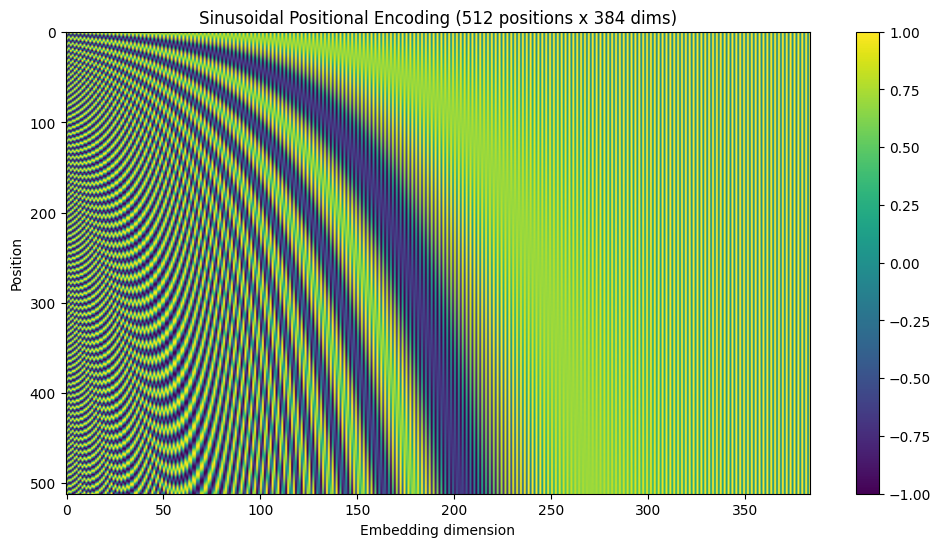

In [47]:
def sinusoid_positional_encoding(max_len, d_model):
    pe = np.zeros((max_len, d_model))
    position = np.arange(max_len)[:, np.newaxis]  # (1, max_len)
    div_term = 10000 ** (np.arange(0, d_model, 2) / d_model)  # (d_model,)
    
    pe[:, 0::2] = np.sin(position / div_term)
    pe[:, 1::2] = np.cos(position / div_term)
    
    return pe

pe = sinusoid_positional_encoding(max_sequence_length, d_model)

plt.figure(figsize=(12, 6))
plt.imshow(pe, aspect='auto', cmap="viridis")
plt.colorbar()
plt.title(f"Sinusoidal Positional Encoding ({max_sequence_length} positions x {d_model} dims)")
plt.xlabel("Embedding dimension")
plt.ylabel("Position")
plt.show()

In [48]:
pe_batched = pe[np.newaxis, :, :]  # (1, max_sequence_length, embedding_dim)
input_embedding = embedded_batch + pe

input_embedding[0].shape

(32, 512, 384)

In [49]:
def unbroadcast(grad, shape):
    """
    Reduce grad (np.array) to match `shape` by summing over broadcasted axes.
    Works when grad.shape >= shape (NumPy broadcasting rules).
    """
    grad = np.array(grad) # ensure ndarray
    # If shape is scalar
    if shape == ():
        return grad.sum()
    
    # 1) sum leading axes if grad has more dims than shape
    while grad.ndim > len(shape):
        grad = grad.sum(axis=0)

    # 2) for dims where original shape ==1 but grad dim >1, sum along that axis
    for i, dim in enumerate(shape):
        if dim == 1 and grad.shape[i] > 1:
            grad = grad.sum(axis=i, keepdims=True)
        
    # Finally, ensure shape equality
    if grad.shape != tuple(shape):
        grad = grad.reshape(shape)
        
    return grad

class Tensor:
    def __init__(self, data, requires_grad: bool=False):
        self.data = np.array(data, dtype=np.float32)
        self.requires_grad = requires_grad
        self.grad = None
        self.grad_fn = None  # The function that created this tensor (used for backpropagation)
        
    def zero_grad(self, recursive=True):
        """
        Reset grad for this tensor (and optionally all tensors in the graph).
        If recursive=True, traverses the computational graph to clear all grads.
        """
        visited = set()
        self._zero_grad_recursive(visited) if recursive else setattr(self, "grad", None)
        
    def _zero_grad_recursive(self, visited: set):
        if self in visited:
            return
        
        visited.add(self)
              
        # Reset current grad
        if self.requires_grad:
            self.grad = None
            
        # Continue to parents
        if self.grad_fn:
            for p in self.grad_fn.parents:
                p._zero_grad_recursive(visited)
    
    def backward(self, grad_output=None):
        if grad_output is None:
            grad_output = np.ones_like(self.data)    
        self.grad = grad_output 
        
        visited = set()
        topo = []
        self._build_topo(topo, visited)
        
        for t in reversed(topo):
            if t.grad_fn is None:
                continue
            
            grad_out = t.grad
            if grad_out is None:
                grad_out = np.ones_like(t.data)
                
            grads = t.grad_fn.backward(t.grad_fn.ctx, grad_out)
            if not isinstance(grads, (tuple, list)):
                grads = (grads,) 
                
            parents = t.grad_fn.parents
            # If lengths differ, try to align
            for parent, g in zip(t.grad_fn.parents, grads):
                if parent.requires_grad:
                    # reduce gradient to parent's original shape
                    g_reduced = unbroadcast(g, parent.data.shape)
                    parent.grad = (parent.grad + g_reduced) if parent.grad is not None else g_reduced

    def _build_topo(self, topo, visited):
        if self not in visited:
            visited.add(self)
            if self.grad_fn:
                for p in self.grad_fn.parents:
                    p._build_topo(topo, visited)
                    
            topo.append(self)
        
    # convenience ops (wrap scalars to Tensor without auto requires_grad)
    def _wrap(self, other):
        return other if isinstance(other, Tensor) else Tensor(other)
        
    def __add__(self, other):
        other = self._wrap(other)
        return Add.apply(self, other)
    
    def __radd__(self, other):
        other = self._wrap(other)
        return Add.apply(other, self)
    
    def __sub__(self, other):
        other = self._wrap(other)
        return Sub.apply(self, other)
    
    def __rsub__(self, other):
        other = self._wrap(other)
        return Sub.apply(other, self)
    
    def __mul__(self, other):
        other = self._wrap(other)
        return Mul.apply(self, other)
    
    def __rmul__(self, other):
        other = self._wrap(other)
        return Mul.apply(other, self)
    
    def __pow__(self, other):
        other = self._wrap(other)
        return Pow.apply(self, other)
    
    def __rpow__(self, other):
        other = self._wrap(other)
        return Pow.apply(other, self)
    
    def __truediv__(self, other):
        other = self._wrap(other)
        return Div.apply(self, other)
    
    def __rtruediv__(self, other):
        other = self._wrap(other)
        return Div.apply(other, self)
    
    def __neg__(self):
        return Neg.apply(self)
    
    def tanh(self):
        return Tanh.apply(self)

    def log(self):
        return Log.apply(self)

    def sqrt(self):
        return Sqrt.apply(self)

    def exp(self):
        return Exp.apply(self)

    def softmax(self):
        return Softmax.apply(self)
    
    def matmul(self, other):
        other = self._wrap(other)
        return MatMul.apply(self, other)
    
    def linear(self, W, b=None):
        out = self.matmul(W)
        if b is not None:
            out = out + b
        return out
    
    def relu(self):
        return ReLU.apply(self)
    
    def sum(self, axis=None, keepdims=False):
        return Sum.apply(self, axis, keepdims)
            
    def __repr__(self):
        return f"Tensor(data={self.data}, grad={self.grad}, requires_grad={self.requires_grad})"
    
class Function:
    @classmethod
    def apply(cls, *inputs):
        ctx = {}    
        raw_inputs = [i.data if isinstance(i, Tensor) else i for i in inputs]
        out_data = cls.forward(ctx, *raw_inputs)
        out = Tensor(out_data)
        out.requires_grad = any(getattr(i, "requires_grad", False) for i in inputs)
        fn = cls()
        fn.ctx = ctx
        fn.parents = [i for i in inputs if isinstance(i, Tensor)]
        out.grad_fn = fn
        
        return out
        
class Add(Function):
    @staticmethod 
    def forward(ctx: dict, a, b):
        ctx["a_shape"] = a.shape
        ctx["b_shape"] = b.shape
        
        return a + b
    
    @staticmethod 
    def backward(ctx: dict, grad_output):
        return grad_output, grad_output
    
class Sub(Function):
    @staticmethod
    def forward(ctx: dict, a, b):
        ctx["a"], ctx["b"] = a, b
        return a - b
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        return grad_output, -grad_output  

class Neg(Function):
    @staticmethod
    def forward(ctx: dict, a):
        return -a
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        # d(-a)/da = -1
        return -grad_output
    
class Mul(Function):
    @staticmethod
    def forward(ctx: dict, a, b):
        ctx["a"], ctx["b"] = a, b
        return a * b
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        return grad_output * ctx["b"], grad_output * ctx["a"]  
    
class Pow(Function):
    @staticmethod
    def forward(ctx: dict, a, power):
        ctx["a"], ctx["p"] = a, power
        return a ** power
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        a, p = ctx['a'], ctx['p']
        grad_a = grad_output * p * (a ** (p - 1))
        # attempt grad wrt p if p is tensor-like; if p scalar, the caller likely won't require grad
        try:
            grad_p = grad_output * (a ** p) * np.log(a + 1e-9)
            return grad_a, grad_p
        except Exception:
            return grad_a, None
    
class Div(Function):
    @staticmethod
    def forward(ctx: dict, a, b):
        ctx["a"], ctx["b"] = a, b
        return a / b
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        a, b = ctx["a"], ctx["b"]
        return grad_output * (1 / b), grad_output * (-a / (b ** 2))
    
class Tanh(Function):
    @staticmethod
    def forward(ctx: dict, a):
        out = np.tanh(a)
        ctx["out"] = out
        return out
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        # d(tanh(x))/dx = 1 - tanh^2(x)
        return grad_output * (1 - ctx["out"] ** 2)
    
class Log(Function):
    @staticmethod
    def forward(ctx, a):
        ctx["a"] = a
        return np.log(a + 1e-9)  # avoid log(0)
    
    @staticmethod
    def backward(ctx, grad_output):
        a = ctx["a"]
        return grad_output * (1 / (a + 1e-9))
    
class Sqrt(Function):
    @staticmethod
    def forward(ctx, a):
        out = np.sqrt(a)
        ctx["out"] = out
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * (0.5 / (ctx["out"] + 1e-9))

class Exp(Function):
    @staticmethod
    def forward(ctx, a):
        out = np.exp(a)
        ctx["out"] = out
        return out

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output * ctx["out"]

class Softmax(Function):
    @staticmethod
    def forward(ctx, x):
        x_shifted = x - np.max(x, axis=-1, keepdims=True)
        exp_x = np.exp(x_shifted)
        out = exp_x / (exp_x.sum(axis=-1, keepdims=True) + 1e-9)
        ctx["out"] = out
        return out

    @staticmethod
    def backward(ctx, grad_output):
        y = ctx["out"]
        grad = y * (grad_output - (grad_output * y).sum(axis=-1, keepdims=True))
        
        return grad
    
class MatMul(Function):
    @staticmethod
    def forward(ctx: dict, a, b):
        ctx["a"], ctx["b"] = a, b
        return a @ b
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        a, b = ctx["a"], ctx["b"]
        grad_a = grad_output @ b.T
        grad_b = a.T @ grad_output
        
        return grad_a, grad_b
    
class ReLU(Function):
    @staticmethod
    def forward(ctx: dict, a):
        ctx["mask"] = (a > 0).astype(np.float32)
        return a * ctx["mask"]
    
    @staticmethod
    def backward(ctx: dict, grad_output):
        return grad_output * ctx["mask"]
    
class Sum(Function):
    @staticmethod
    def forward(ctx: dict, a, axis=None, keepdims=False):
        ctx["a_shape"] = a.shape
        ctx["axis"] = axis
        ctx["keepdims"] = keepdims
        
        return np.sum(a, axis=axis, keepdims=keepdims)

    @staticmethod
    def backward(ctx, grad_output):
        # grad sum = 1
        a_shape = ctx["a_shape"]
        axis = ctx["axis"]
        keepdims = ctx["keepdims"]
        
        if not keepdims and axis is not None:
            grad_output = np.expand_dims(grad_output, axis)
        grad = np.ones(a_shape, dtype=np.float32) * grad_output
        
        return grad

In [50]:
def grad_check(func, inputs, eps=1e-3, tol=1e-2):
    # Ensure no stale grads
    for x in inputs:
        x.zero_grad(recursive=False)
        
    out = func(*inputs)
    # zero grads again to be safe (if func used some intermediate tensors)
    for x in inputs:
        x.zero_grad(recursive=False)
        
    out.backward()
    analytic_grads = [x.grad.copy() for x in inputs]

    num_grads = []
    for i, x in enumerate(inputs):
        grad = np.zeros_like(x.data)
        it = np.nditer(x.data, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = x.data[idx]
            
            x.data[idx] = orig + eps
            plus = func(*inputs).data.copy()
            
            x.data[idx] = orig - eps
            minus = func(*inputs).data.copy()
            
            x.data[idx] = orig
            
            # If plus or minus contains NaN, raise informative error
            if np.isnan(plus).any() or np.isnan(minus).any():
                raise ValueError(f"NaN encountered during numeric check for param {i} at index {idx}.\n"
                                f"plus={plus}, minus={minus}\n"
                                "Likely domain error (e.g. negative**non-integer, log(<=0), sqrt(neg)).")
            
            grad[idx] = np.sum((plus - minus) / (2 * eps))
            it.iternext()

        num_grads.append(grad)
        
    for i, (a, n) in enumerate(zip(analytic_grads, num_grads)):
        diff = np.abs(a - n).max()
        print(f"Param {i}: max|analytic - numeric| = {diff:.6e}")
        assert diff < tol, f"Gradient check failed for param {i} (diff={diff})"

    print("Gradient check passed!")

In [51]:
x = Tensor(np.random.randn(3, 3), requires_grad=True)
y = Tensor(np.random.randn(3, 3), requires_grad=True)

def f(a, b): 
    return (a + b).sum()

grad_check(f, [x, y])

Param 0: max|analytic - numeric| = 7.253885e-05
Param 1: max|analytic - numeric| = 1.659393e-04
Gradient check passed!


In [52]:
def test_all_grads():
    # --- 1. Add ---
    x = Tensor(np.random.randn(3, 3), requires_grad=True)
    y = Tensor(np.random.randn(3, 3), requires_grad=True)
    grad_check(lambda a, b: (a + b).sum(), [x, y])

    # --- 2. Sub ---
    grad_check(lambda a, b: (a - b).sum(), [x, y])

    # --- 3. Mul ---
    grad_check(lambda a, b: (a * b).sum(), [x, y])

    # --- 4. Div ---
    grad_check(lambda a, b: (a / (b + 2)).sum(), [x, y])  

    # --- 5. Pow ---
    # make base positive and bounded away from zero, exponent also shifted
    grad_check(lambda a, b: ((a * 0.5 + 2.0) ** (b * 0.5 + 2.0)).sum(), [x, y])

    # --- 6. Tanh ---
    grad_check(lambda a: a.tanh().sum(), [x])

    # --- 7. Log ---
    grad_check(lambda a: (a * 0.5 + 1.0).log().sum(), [x])  # avoid log(0)

    # --- 8. Sqrt ---
    grad_check(lambda a: ((a * 0.5 + 2).sqrt()).sum(), [x])

    # --- 9. Exp ---
    grad_check(lambda a: a.exp().sum(), [x])

    # --- 10. Softmax ---
    grad_check(lambda a: a.softmax().sum(), [x])

    # --- 11. MatMul ---
    A = Tensor(np.random.randn(2, 3), requires_grad=True)
    B = Tensor(np.random.randn(3, 4), requires_grad=True)
    grad_check(lambda a, b: a.matmul(b).sum(), [A, B])

    # --- 12. ReLU ---
    grad_check(lambda a: a.relu().sum(), [x])

    # --- 13. Sum ---
    grad_check(lambda a: a.sum(), [x])

    print("\nAll gradient checks passed successfully!")

# Run all gradient checks
test_all_grads()


Param 0: max|analytic - numeric| = 7.253885e-05
Param 1: max|analytic - numeric| = 1.659393e-04
Gradient check passed!
Param 0: max|analytic - numeric| = 1.659393e-04
Param 1: max|analytic - numeric| = 7.253885e-05
Gradient check passed!
Param 0: max|analytic - numeric| = 3.025532e-04
Param 1: max|analytic - numeric| = 2.939105e-04
Gradient check passed!
Param 0: max|analytic - numeric| = 7.113814e-05
Param 1: max|analytic - numeric| = 7.781982e-04
Gradient check passed!
Param 0: max|analytic - numeric| = 1.565456e-03
Param 1: max|analytic - numeric| = 1.811028e-03
Gradient check passed!
Param 0: max|analytic - numeric| = 6.714463e-05
Gradient check passed!
Param 0: max|analytic - numeric| = 1.032352e-04
Gradient check passed!
Param 0: max|analytic - numeric| = 4.973114e-04
Gradient check passed!
Param 0: max|analytic - numeric| = 7.460117e-04
Gradient check passed!
Param 0: max|analytic - numeric| = 2.668268e-08
Gradient check passed!
Param 0: max|analytic - numeric| = 1.270175e-04
Pa

In [53]:
# broadcasting add: x shape (1,3), y shape (2,1) -> z shape (2,3)
x = Tensor(np.array([[1.0, 2.0, 3.0]]), requires_grad=True)   # shape (1,3)
y = Tensor(np.array([[10.0], [20.0]]), requires_grad=True)    # shape (2,1)
z = x + y  # broadcast to (2,3)
# backprop with ones
z.backward(np.ones_like(z.data))
print("x.grad.shape:", x.grad.shape)  # expected (1,3)
print("y.grad.shape:", y.grad.shape)  # expected (2,1)
print("x.grad:\n", x.grad)
print("y.grad:\n", y.grad)

# scalar left op: 3 + x
a = Tensor(2.0, requires_grad=True)
b = 3 + a
b.backward()
print("a.grad (should be 1):", a.grad)

# mul broadcast: (2,1) * (1,3)
p = Tensor(np.array([[2.0],[3.0]]), requires_grad=True)   # (2,1)
q = Tensor(np.array([[4.0,5.0,6.0]]), requires_grad=True) # (1,3)
r = p * q  # (2,3)
r.backward(np.ones_like(r.data))
print("p.grad.shape:", p.grad.shape)  # (2,1)
print("q.grad.shape:", q.grad.shape)  # (1,3)

x.grad.shape: (1, 3)
y.grad.shape: (2, 1)
x.grad:
 [[2. 2. 2.]]
y.grad:
 [[3.]
 [3.]]
a.grad (should be 1): 1.0
p.grad.shape: (2, 1)
q.grad.shape: (1, 3)


In [54]:
x = Tensor(2.0, requires_grad=True)

y = x.tanh() + x.log() + x.sqrt()
y.backward()

print("y =", y.data)
print("dy/dx =", x.grad)
print(1 - np.tanh(x.data) ** 2 + 1 / x.data + 1 / (2 * np.sqrt(x.data)))

y = 3.0713882
dy/dx = 0.92420423
0.92420423


In [55]:
x = Tensor([2.0, 3.0], requires_grad=True)
y = Tensor([1.5, 2.5], requires_grad=True)
z = (x * y).sum()

z.backward()
print("Before zero_grad:")
print("x.grad =", x.grad)
print("y.grad =", y.grad)

# Reset all gradient in graph (include x and y)
z.zero_grad()
print("\nAfter zero_grad:")
print("x.grad =", x.grad)
print("y.grad =", y.grad)

Before zero_grad:
x.grad = [1.5 2.5]
y.grad = [2. 3.]

After zero_grad:
x.grad = None
y.grad = None


In [56]:
def rand_mat(a: int, b: int):
    return np.random.randn(a, b).astype(np.float32)

attn_params = {
    "bq": np.zeros((d_model,), dtype=np.float32),
    "bk": np.zeros((d_model,), dtype=np.float32),
    "bv": np.zeros((d_model,), dtype=np.float32),
    "W0": np.zeros((d_model,), dtype=np.float32),
    "b0": np.zeros((d_model,), dtype=np.float32),
} 

for n in range(num_heads):
    attn_params[f"Wq{n}"] = rand_mat(d_model, head_dim)
    attn_params[f"Wk{n}"] = rand_mat(d_model, head_dim)
    attn_params[f"Wv{n}"] = rand_mat(d_model, head_dim)
    
d_ff = d_model * 4
fn_params = {
    "W1": rand_mat(d_model, d_ff),
    "b1": np.zeros((d_model,), dtype=np.float32),
    "W2": rand_mat(d_ff, d_model),
    "b2": np.zeros((d_model,), dtype=np.float32),
}

ln_params = {
    "gamma": Tensor(np.ones((d_model,), dtype=np.float32)),
    "beta": Tensor(np.zeros((d_model,), dtype=np.float32))
}

In [ ]:
def gelu(x: Tensor):
    c = np.sqrt(2 / np.pi)
    
    return 0.5 * x * (1 + ((c * (x + 0.044715 * (x ** 3))).tanh()))

def feed_forward(x, params: dict):
    W1, b1 = params["W1"], params.get("b1", None)
    W2, b2 = params["W2"], params.get("b2", None)
    
    h = x.linear(W1, b1)
    h = gelu(h)
    out = h.linear(W2, b2)
    
    return out   

def layer_norm(x, gamma, beta, eps=1e-5):
    mean = x.mean(axis=-1, keepdims=True)
    var = x.var(axis=-1, keepdims= True)
    normed = (x - mean) / np.sqrt(var + eps)
    
    return gamma * normed + beta

def dropout(x: Tensor, p=0.1, training=True):
    if not training or p == 0.0:
        return x
    
    mask = (np.random.rand(*x.data.shape) > p).astype(np.float32)
    mask = Tensor(mask)
    
    return (x * mask) / (1.0 - p)

def multi_head_attention(X, params:dict, num_heads: int=6):
    batch_size, seq_len, d_model = X.shape
    head_dim = d_model // num_heads
    all_heads = []
    
    for n in range(num_heads):
        Wq = params[f"Wq{n}"]
        Wk = params[f"Wk{n}"]
        Wv = params[f"Wv{n}"]
        
        Q = X.matmul(Wq)
        K = X.matmul(Wk)
        V = X.matmul(Wv)
        
        # (batch, seq_len, head_dim) @ (batch, head_dim, seq_len) -> (batch, seq_len, seq_len)
        K_T = K.data.transpose(0, 2, 1)
        scores = Q.matmul(Tensor(K_T)) / Tensor(np.sqrt(head_dim))
        
        mask = np.triu(np.ones((seq_len, seq_len)), k=1) * -1e9
        scores = scores + Tensor(mask[np.newaxis, :, :])
        
        attn = Tensor.softmax(scores, axis=-1)
        
        head_out = attn.matmul(V)
        all_heads.append(head_out)
        
    concat = Tensor(np.concatenate(all_heads, axis=-1))  # batch, seq_len, d_model
    
    # final output projection
    W0 = Tensor(params["W0"])
    b0 = Tensor(params["b0"])
    out = concat.matmul(W0) + b0
    
    return out

def gpt_decoder_block(X, num_heads, attn_params, ffn_params, ln_params, ln_eps=1e-5):
    gamma1, beta1 = ln_params["gamma1"], ln_params["beta1"]
    gamma2, beta2 = ln_params["gamma2"], ln_params["beta2"]
    
    # LayerNorm + Self-Attention
    X_norm = layer_norm(X, gamma1, beta1)
    attn_out = multi_head_attention(X_norm, attn_params, num_heads)
    attn_out = dropout(attn_out, p=0.1)
    attn_out = X + attn_out  # residual
    
    # LayerNorm + Feed Forward
    attn_norm = layer_norm(attn_out, gamma2, beta2)
    ffn_out = feed_forward(attn_norm, ffn_params)
    ffn_out = dropout(ffn_out, p=0.1)
    out = attn_out + ffn_out 
    
    return out